In [18]:
import networkx as nx
import requests
import json
import matplotlib.pyplot as plt

url = '10.168.20.20:5010'

In [19]:
pipeline = [
    {'$match': {'name': {'$in': ['app2', 'app5']}, 'roles._id': '5afdb8cf93beb10025c13f4f'}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {'name': 1, 'deps': 1, 'deps': 1, 'nodes.name': 1, 'nodes.steps': 1, 'nodes.deps': 1}}
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()
print(data)

{'items': [{'nodes': [{'name': 'app4', 'steps': 1, 'deps': [{'endpoint': 'rest', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database', 'name': 'Db - mysql'}]}, {'name': 'Db - mysql', 'steps': 1}, {'name': 'broker', 'steps': 1}, {'name': 'app1', 'steps': 0, 'deps': [{'endpoint': 'rest', '_id': '5b29836b3dee72509767a790', 'family': 'Broker', 'name': 'broker'}, {'endpoint': 'rest', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database', 'name': 'Db - mysql'}, {'endpoint': 'rest', '_id': '5b3d1b0ed7f17a0025e48d33', 'family': 'Application', 'name': 'app4'}]}], '_id': '5b293d045ec68b1828d5fa7e', 'name': 'app2', 'deps': [{'endpoint': 'rest', '_id': '5b293cff5ec68b1828d5fa7d', 'family': 'Application', 'name': 'app1'}]}, {'nodes': [{'name': 'Db - mysql', 'steps': 0}], '_id': '5b3d1b4fd7f17a0025e48d34', 'name': 'app5', 'deps': [{'endpoint': 'rest', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database', 'name': 'Db - mysql'}]}]}


In [110]:
class BaseNetwork(object):
    def __init__(self, G=nx.DiGraph):
        self.graph = G()

    def create_edge(self, parent, item):
        if 'deps' in parent:
            for dps in parent['deps']:
                w = item.get('steps', -1)
                self.graph.add_edge(item['name'], dps['name'], weight=w+1)

    def create_node(self, item):
        self.graph.add_node(item['name'], label=item['name'], object=item)

    def make(self, data):
        for item in data:
            self.create_node(item)
            self.create_edge(item, item)

            for sub in item['nodes']:
                self.create_node(sub)
                self.create_edge(sub, sub)

        return self

    def get_graph(self):
        return self.graph

    
class DrawNetwork(object):

    def __init__(self, G):
        self.graph = G
        
    def get_cardials(self):
        return nx.circular_layout(self.graph)
    
    
    def save_svg(self, options, labels):
        #plt.figure(figsize=(4, 4))
        pos = self.get_cardials()

        nx.draw(self.graph, pos, **options)

        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)

        plt.axis('equal')
        plt.show()
        return pos

network = BaseNetwork()
network.make(data.get('items')).get_graph()

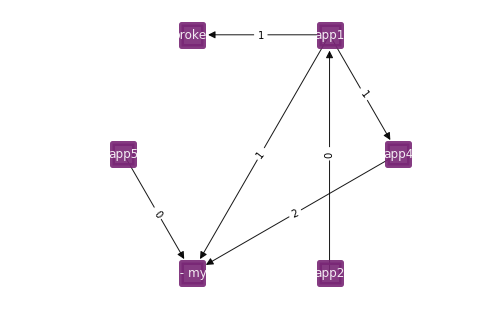

{'app4': array([1.00000000e+00, 2.45045699e-08]), 'app1': array([0.49999998, 0.86602546]), 'Db - mysql': array([-0.49999989, -0.86602541]), 'app5': array([-9.99999970e-01, -6.29182054e-08]), 'broker': array([-0.50000004,  0.8660254 ]), 'app2': array([ 0.49999992, -0.86602541])}


In [111]:
options = {
    'with_labels': True,
    'arrowsize': 15,
    'node_shape': 's',
    'node_size': 500,
    'node_color': '#782675',
    'font_color': 'white',
    'alpha': 0.9,
    'linewidths': 5
}

labels = {
    'font_weight': 'bold'
}

draw = DrawNetwork(network.graph)
draw.save_svg(options, labels)

print(draw.get_cardials())

In [112]:
G=network.graph
nei = list(network.graph.neighbors('app1'))
print(nei)

network.graph.degree['app5']

G.out_degree('app5')
G.in_degree('app5')

['Db - mysql', 'app4', 'broker']


0

In [23]:
nx.pagerank(G, alpha=0.9)

nx.degree_histogram(G)

nx.density(G)

0.2

In [216]:
import svgwrite
from operator import itemgetter
from IPython.display import SVG, display

entry = ['app5', 'app2']
dwg = svgwrite.Drawing('test.svg', profile='full')

opts = {
    'size': ("20px", "20px"),
    'stroke_width': "1",
    'stroke': "black",
    'fill': "rgb(255,255,0)"
}






def draw_square(x, y):
    dwg.add(dwg.rect(insert = (x, y), **opts))

    
class nn(object):
    def __init__(self):
        self.base = 60
        self.old_weight = 0
        self.new_weight = 0

        self.top = 0
        
    def recursive_draw(self,edges):

        for item in edges:
            print(item)
            #print(G.node[item]['label'])


            pred = G.in_edges(item, data=True)
            if pred and len(list(pred)) > 0:
                self.new_weight = max([it[2].get('weight') for it in pred])


            if self.old_weight == self.new_weight:
                self.top = self.top + 1
            else:
                self.top = 0
                self.old_weight = self.new_weight

            print(top)
            x = base * self.new_weight
            y = base * self.top  
            succ = G.successors(item)

            draw_square(x, y)
            self.recursive_draw(succ)

        
        
    
    
nn().recursive_draw(entry)    


dwg.save()
display(SVG(filename='test.svg'))

app5
0
Db - mysql
0
app2
0
app1
0
Db - mysql
0
app4
0
Db - mysql
0
broker
0
